In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
import nltk
import re
import pickle
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity

In [14]:
movies_df = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\movie_data.csv')

C:\Users\Cisco\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
movies_df.head(1)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0


# 1) Data Cleaning and Wrangling

#   1.1) Movies

In [4]:
from tqdm import tqdm
from time import sleep
from imdb import IMDb

In [16]:
# Drop unnecessary columns for our analysis

movies_df.drop(columns= ['original_title', 'language','reviews_from_users','reviews_from_critics','usa_gross_income',
                      'worlwide_gross_income','metascore','budget'], inplace= True)

In [17]:
movies_df.head()

,imdb_title_id,title,year,date_published,genre,duration,country,director,writer,production_company,actors,description,avg_vote,votes
0,tt0000009,Miss Jerry,1894,1894-10-09,Romance,45,USA,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154
1,tt0000574,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589
2,tt0001892,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188
3,tt0002101,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446
4,tt0002130,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237


In [18]:
# Replace with actualy date of movie release

movies_df.year.replace({'TV Movie 2019': '2019'}, inplace= True)
movies_df.date_published.replace({'TV Movie 2019': '2019-09-09'}, inplace = True)

In [19]:
# Check to make sure previous code worked

movies_df.loc[movies_df.date_published == 'TV Movie 2019']

,imdb_title_id,title,year,date_published,genre,duration,country,director,writer,production_company,actors,description,avg_vote,votes


In [20]:
# Change data type to from object to datetime

movies_df.year = movies_df.year.astype(str).astype(int)
movies_df['date_published'] = pd.to_datetime(movies_df['date_published'])

In [21]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   imdb_title_id       85855 non-null  object        
 1   title               85855 non-null  object        
 2   year                85855 non-null  int32         
 3   date_published      85855 non-null  datetime64[ns]
 4   genre               85855 non-null  object        
 5   duration            85855 non-null  int64         
 6   country             85791 non-null  object        
 7   director            85768 non-null  object        
 8   writer              84283 non-null  object        
 9   production_company  81400 non-null  object        
 10  actors              85786 non-null  object        
 11  description         83740 non-null  object        
 12  avg_vote            85855 non-null  float64       
 13  votes               85855 non-null  int64     

In [22]:
movies_df.head(1)

,imdb_title_id,title,year,date_published,genre,duration,country,director,writer,production_company,actors,description,avg_vote,votes
0,tt0000009,Miss Jerry,1894,1894-10-09,Romance,45,USA,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154


In [23]:
movies_df.shape

(85855, 14)

In [24]:
# We're going to narrow it down to the top 10,000 for computational feasability and practicality

movies_df = movies_df.sort_values('votes', ascending= False)[:10000]

In [25]:
movies_df.shape

(10000, 14)

In [294]:
movies_df.head(5)

,title,year,date_published,genre,duration,country,director,writer,production_company,actors,description,avg_vote,votes
imdb_title_id,,,,,,,,,,,,,
tt0111161,Le ali della libertà,1994,1995-02-10,Drama,142,USA,Frank Darabont,"Stephen King, Frank Darabont",Castle Rock Entertainment,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,9.3,2278845
tt0468569,Il cavaliere oscuro,2008,2008-07-23,"Action, Crime, Drama",152,"USA, UK",Christopher Nolan,"Jonathan Nolan, Christopher Nolan",Warner Bros.,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...,9.0,2241615
tt1375666,Inception,2010,2010-09-24,"Action, Adventure, Sci-Fi",148,"USA, UK",Christopher Nolan,Christopher Nolan,Warner Bros.,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",A thief who steals corporate secrets through t...,8.8,2002816
tt0137523,Fight Club,1999,1999-10-29,Drama,139,"USA, Germany",David Fincher,"Chuck Palahniuk, Jim Uhls",Fox 2000 Pictures,"Edward Norton, Brad Pitt, Meat Loaf, Zach Gren...",An insomniac office worker and a devil-may-car...,8.8,1807440
tt0110912,Pulp Fiction,1994,1994-10-28,"Crime, Drama",154,USA,Quentin Tarantino,"Quentin Tarantino, Roger Avary",Miramax,"Tim Roth, Amanda Plummer, Laura Lovelace, John...","The lives of two mob hitmen, a boxer, a gangst...",8.9,1780147


In [27]:
# Set index to imdb title id

movies_df.set_index('imdb_title_id', inplace= True)

In [19]:
# Shall create a separate variable with all the IDs of the top 10,000 movies in a list

movies_index= movies_df.index

In [20]:
movies_index

Index(['tt0111161', 'tt0468569', 'tt1375666', 'tt0137523', 'tt0110912',
       'tt0109830', 'tt0133093', 'tt0120737', 'tt0167260', 'tt0068646',
       ...
       'tt3203620', 'tt0041859', 'tt0364986', 'tt0064106', 'tt0119324',
       'tt3703908', 'tt0099951', 'tt2054790', 'tt0950739', 'tt0294594'],
      dtype='object', name='imdb_title_id', length=10000)

In [22]:
# Instantiate IMDb()

ia = IMDb()

In [25]:
# Make a dictionary to store keywords from API with respect to their imbd id number

keywords_dict = {}

for movie_index in tqdm(movies_index):    # Displays the progress of the for-loop
    try:
        keywords_dict[movie_index] = ia.get_movie_keywords(movie_index[2:])['data']['keywords']
    except:
        keywords_dict[movie_index] = ''   

100%|██████████| 10000/10000 [1:04:10<00:00,  2.60it/s]


In [87]:
# Convert dictionary into a Dataframe with each word having their own columns

keywords_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in keywords_dict.items()])).transpose()
keywords_df

,0,1,2,3,4,5,6,7,8,9,...,863,864,865,866,867,868,869,870,871,872
tt0111161,wrongful-imprisonment,based-on-the-works-of-stephen-king,prison,escape-from-prison,voice-over-narration,1940s,police-brutality,prison-cell-search,friendship-between-men,infidelity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0468569,dc-comics,joker,psychopath,clown,criminal-mastermind,scarred-face,superhero,moral-dilemma,clown-mask,dual-identity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt1375666,dream,ambiguous-ending,subconscious,mindbender,surprise-ending,psycho-thriller,strong-female-character,architecture,psychological-manipulation,falling-from-height,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0137523,fighting,surprise-ending,anti-establishment,insomnia,multiple-personality-disorder,based-on-novel,group-therapy,anti-conformity,anti-capitalism,disturbed-individual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0110912,nonlinear-timeline,overdose,drug-use,drug-overdose,bondage,drug-dealing,neo-noir,car-accident,dance-contest,black-comedy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt3703908,21st-century,child,girl,house,weapon,silencer-pistol,silenced-pistol,silenced-gun,year-2015,psychological-warfare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0099951,proles,gangster,real-life-siblings-as-fictional-siblings,cockney,brutality,boxing,brother-brother-relationship,mother-son-relationship,london-england,weeping-man,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt2054790,16th-century,fight-for-justice,france,male-pubic-hair,army,travesty-of-justice,self-justice,seeking-justice,revenge,murder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0950739,knights-templar,eastern-europe,sword-and-shield,weapon,cavalry,kingdom,king,second-part,sequel,medieval-times,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# We will then remove any NaN values, and join each keyword into one string

keywords_df = keywords_df.apply(lambda x: ','.join(x.dropna()), axis= 1)

In [89]:
keywords_df.head()

tt0111161    wrongful-imprisonment,based-on-the-works-of-st...
tt0468569    dc-comics,joker,psychopath,clown,criminal-mast...
tt1375666    dream,ambiguous-ending,subconscious,mindbender...
tt0137523    fighting,surprise-ending,anti-establishment,in...
tt0110912    nonlinear-timeline,overdose,drug-use,drug-over...
dtype: object

In [93]:
# Convert back to DataFrame and rename column

keywords_df = pd.DataFrame(keywords_df)
keywords_df.rename(columns= {0: 'keywords'}, inplace= True)
keywords_df.head()

,keywords
tt0111161,"wrongful-imprisonment,based-on-the-works-of-st..."
tt0468569,"dc-comics,joker,psychopath,clown,criminal-mast..."
tt1375666,"dream,ambiguous-ending,subconscious,mindbender..."
tt0137523,"fighting,surprise-ending,anti-establishment,in..."
tt0110912,"nonlinear-timeline,overdose,drug-use,drug-over..."


In [94]:
# Save dataframe to folder so we don't have to re-run above code

keywords_df.to_csv(path_or_buf= 'keywords_df.csv')

In [4]:
# Load csv file

keywords_df = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\keywords_df.csv')

In [5]:
keywords_df.head(1)

,Unnamed: 0,keywords
0,tt0111161,"wrongful-imprisonment,based-on-the-works-of-st..."


In [6]:
# Rename column to match that from our original data

keywords_df.rename(columns= {'Unnamed: 0': 'imdb_title_id'}, inplace= True)

In [7]:
keywords_df.columns

Index(['imdb_title_id', 'keywords'], dtype='object')

In [8]:
# Set the title id column as the dataframe index

keywords_df.set_index('imdb_title_id', inplace= True)

In [28]:
# Join the keywords_df dataframe with the movies_df dataframe created previously with the matching imdb_title_id

movies = movies_df.join(keywords_df, how='inner')

In [28]:
movies.head(1)

,title,year,date_published,genre,duration,country,director,writer,production_company,actors,description,avg_vote,votes,keywords
imdb_title_id,,,,,,,,,,,,,,
tt0111161,Le ali della libertà,1994,1995-02-10,Drama,142,USA,Frank Darabont,"Stephen King, Frank Darabont",Castle Rock Entertainment,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,9.3,2278845,"wrongful-imprisonment,based-on-the-works-of-st..."


In [80]:
# Save File

movies.to_csv(path_or_buf= 'movies.csv')

# 1.2) TV Series

In [12]:
# For TV series shall perform the same steps as we did in the Section 1.1

tv_df = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\tv_series_data.csv')
tv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         6679 non-null   object 
 1   primaryTitle   6679 non-null   object 
 2   genres         6679 non-null   object 
 3   numVotes       6679 non-null   int64  
 4   averageRating  6679 non-null   float64
 5   startYear      6678 non-null   float64
 6   SeriesName     6679 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 365.4+ KB


In [13]:
# Look for any NaN values

tv_df.loc[tv_df.startYear.isna()]

,tconst,primaryTitle,genres,numVotes,averageRating,startYear,SeriesName
2615,tt10042110,BOSS: Baap of Special Services,Action,1976,8.0,NaN,BOSS: Baap of Special Services ()


In [14]:
# Replace NaN value with the year the tv series came out

tv_df.startYear.fillna(2019, inplace= True)

In [15]:
# Change data type in column to integer

tv_df.startYear = tv_df.startYear.astype(int)

In [16]:
tv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         6679 non-null   object 
 1   primaryTitle   6679 non-null   object 
 2   genres         6679 non-null   object 
 3   numVotes       6679 non-null   int64  
 4   averageRating  6679 non-null   float64
 5   startYear      6679 non-null   int32  
 6   SeriesName     6679 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 339.3+ KB


In [17]:
tv_df.shape

(6679, 7)

In [18]:
# Sort dataframe in ascending order from most votes to least - Although not entirely necessary for the tv datafram

tv_df = tv_df.sort_values('numVotes', ascending= False)

In [19]:
# Change name of column with id values

tv_df.rename(columns= {'tconst': 'imdb_tv_id'}, inplace= True)

In [20]:
# Set the IDs of each TV series to index

tv_df.set_index('imdb_tv_id', inplace= True)

In [21]:
tv_df.head(1)

,primaryTitle,genres,numVotes,averageRating,startYear,SeriesName
imdb_tv_id,,,,,,
tt0944947,Game of Thrones,"Action,Adventure,Drama",1760872,9.3,2011,Game of Thrones (2011)


In [15]:
# Make a separate list of the IDs of each tv series

tv_indexes = tv_df.index

In [16]:
tv_indexes

Index(['tt0944947', 'tt0903747', 'tt1520211', 'tt0108778', 'tt4574334',
       'tt1475582', 'tt0898266', 'tt0773262', 'tt0460649', 'tt7366338',
       ...
       'tt0239185', 'tt0294177', 'tt0053496', 'tt0457544', 'tt0448300',
       'tt2256612', 'tt0158421', 'tt1872328', 'tt1329291', 'tt0163488'],
      dtype='object', name='imdb_tv_id', length=6679)

In [23]:
# Make a dictionary to store keywords from API with respect to their imbd id number

tv_keywords_dict= {}

for tv_index in tqdm(tv_indexes):
    try:
        tv_keywords_dict[tv_index] = ia.get_movie_keywords(tv_index[2: ])['data']['keywords']
    except:
        tv_keywords_dict[tv_index] = ''

 36%|███▌      | 2384/6679 [24:19<1:03:26,  1.13it/s]2021-06-29 20:37:54,515 CRITICAL [imdbpy] C:\Users\Cisco\anaconda3\lib\site-packages\imdb\_exceptions.py:34: IMDbDataAccessError exception raised; args: ({'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/title/tt0088580/keywords', 'proxy': '', 'exception type': 'IOError', 'original exception': timeout('The read operation timed out')},); kwds: {}
Traceback (most recent call last):
  File "C:\Users\Cisco\anaconda3\lib\site-packages\imdb\parser\http\__init__.py", line 220, in retrieve_unicode
    response = uopener.open(url)
  File "C:\Users\Cisco\anaconda3\lib\urllib\request.py", line 525, in open
    response = self._open(req, data)
  File "C:\Users\Cisco\anaconda3\lib\urllib\request.py", line 543, in _open
    '_open', req)
  File "C:\Users\Cisco\anaconda3\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "C:\Users\Cisco\anaconda3\lib\urllib\request.py", line 1362, in https_open
    conte

In [25]:
# Convert dictionary into a Dataframe with each word having their own columns
# Rejoin each keyword into a string 

tv_keywords_df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in tv_keywords_dict.items()])).transpose()
tv_keywords_df = tv_keywords_df.apply(lambda x: ','.join(x.dropna()), axis= 1)

In [26]:
# Return data to dataframe mode
# Rename columns appropriately

tv_keywords_df = pd.DataFrame(tv_keywords_df)
tv_keywords_df.rename(columns= {0: 'tv_keywords'}, inplace= True)

In [27]:
# Save data to folder

tv_keywords_df.to_csv(path_or_buf= 'tv_keywords_df.csv')

In [5]:
# Load data to folder

tv_keywords_df = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\tv_keywords_df.csv')

In [6]:
# With the data loaded we can rename the columns of IDs appropriately

tv_keywords_df.rename(columns= {'Unnamed: 0': 'imdb_tv_id'}, inplace= True)

In [7]:
tv_keywords_df.head()

,imdb_tv_id,tv_keywords
0,tt0944947,"based-on-novel,dragon,politics,nudity,queen,in..."
1,tt0903747,"cancer,crystal-meth,albuquerque-new-mexico,che..."
2,tt1520211,"zombie,survival,post-apocalypse,based-on-comic..."
3,tt0108778,"friendship,friend,new-york-city,roommate,divor..."
4,tt4574334,"government-conspiracy,cover-up,1980s,mk-ultra,..."


In [8]:
tv_keywords_df.shape

(6679, 2)

In [9]:
tv_keywords_df.set_index('imdb_tv_id', inplace= True)

In [22]:
tv_series = tv_df.join(tv_keywords_df, how='inner')

In [23]:
tv_series

,primaryTitle,genres,numVotes,averageRating,startYear,SeriesName,tv_keywords
imdb_tv_id,,,,,,,
tt0944947,Game of Thrones,"Action,Adventure,Drama",1760872,9.3,2011,Game of Thrones (2011),"based-on-novel,dragon,politics,nudity,queen,in..."
tt0903747,Breaking Bad,"Crime,Drama,Thriller",1454727,9.5,2008,Breaking Bad (2008),"cancer,crystal-meth,albuquerque-new-mexico,che..."
tt1520211,The Walking Dead,"Drama,Horror,Thriller",850008,8.2,2010,The Walking Dead (2010),"zombie,survival,post-apocalypse,based-on-comic..."
tt0108778,Friends,"Comedy,Romance",822174,8.9,1994,Friends (1994),"friendship,friend,new-york-city,roommate,divor..."
tt4574334,Stranger Things,"Drama,Fantasy,Horror",815075,8.7,2016,Stranger Things (2016),"government-conspiracy,cover-up,1980s,mk-ultra,..."
...,...,...,...,...,...,...,...
tt2256612,Crimi Clowns,"Comedy,Crime,Thriller",1002,8.1,2012,Crimi Clowns (2012),NaN
tt0158421,Vengeance Unlimited,"Crime,Drama",1001,8.8,1998,Vengeance Unlimited (1998),"1990s,vengeance,revenge"
tt1872328,Gosick,"Animation,Comedy,Drama",1001,7.4,2011,Gosick (2011),"anime,year-1924,fictional-country,europe,japan..."


In [24]:
# Save TV file

tv_series.to_csv(path_or_buf= 'tv_series.csv')

# 2) Exploratory Data Analysis

#   2.1) Movies

In [98]:
# Checking to see which keywords will fail my for-loop for finding length of characters in keyword

for keywords in movies['keywords']:
    if isinstance(keywords, float) : 
        print(keywords)
    else:
        continue
    
    

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [78]:
# Change the NaN values to 'None'

movies.keywords.fillna('None', inplace= True)
movies.keywords.isnull().value_counts()

False    10000
Name: keywords, dtype: int64

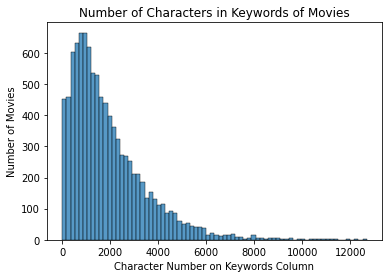

In [172]:
# A for-loop to get length of the keywords of each movie

movie_char_count = []

for keywords in movies['keywords']:
    n_char = len(keywords)
    movie_char_count.append(n_char)
    
_ = sns.histplot(movie_char_count)
_ = plt.ylabel('Number of Movies')
_ = plt.xlabel('Character Number on Keywords Column')
_ = plt.title('Number of Characters in Keywords of Movies')

In [142]:
print(np.mean(movie_char_count))

1910.8302


In [ ]:
# We can see from the chart and the average number of characters in the keywords that the distribution is right tailed.

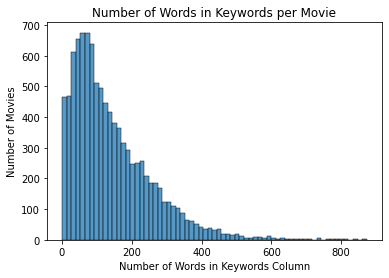

In [167]:
# We'll do the same now, except we will use the number of words instead

movie_word_count = []

for keyword in movies['keywords']:
    word_count = len(keyword.split(','))
    movie_word_count.append(word_count)
    
_ = sns.histplot(movie_word_count)
_ = plt.ylabel('Number of Movies')
_ = plt.xlabel('Number of Words in Keywords Column')
_ = plt.title('Number of Words in Keywords per Movie')

In [146]:
print(np.mean(movie_word_count))

143.1864


 As shown above, the distribution of the graph is right tailed. This makes sense as they are intuitively correlated.
 This tells us that alot of the movies have relatively low amount of keywords

# 2.2) TV Series

In [25]:
# We shall perform the same steps as we did in the Movie section

tv_series.tv_keywords.fillna('None', inplace= True)
tv_series.tv_keywords.isnull().value_counts()

False    6679
Name: tv_keywords, dtype: int64

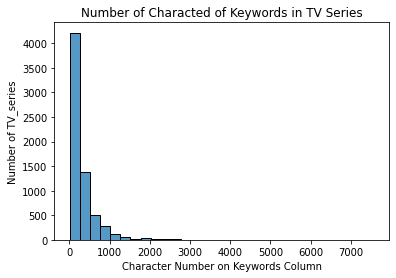

In [58]:

tv_char_count = []

for tv_keyword in tv_series['tv_keywords']:
    n_char = len(tv_keyword)
    tv_char_count.append(n_char)
    
_ = sns.histplot(tv_char_count, bins= 30)
_ = plt.ylabel('Number of TV_series')
_ = plt.xlabel('Character Number on Keywords Column')
_ = plt.title('Number of Characted of Keywords in TV Series')

In [59]:
print(np.mean(tv_char_count))

291.2486899236413


 The distribution of the graph is right tailed with majority of the tv series having less that 250 characters in their
 keywords

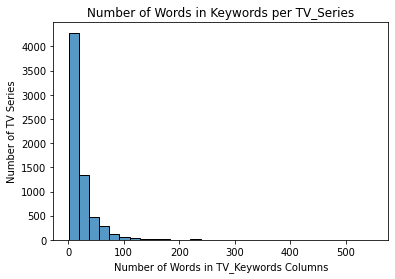

In [60]:
tv_word_count = []
for tv_keyword in tv_series['tv_keywords']:
    word_count = len(tv_keyword.split(','))
    tv_word_count.append(word_count)
    
_ = sns.histplot(tv_word_count, bins= 30)
_ = plt.ylabel('Number of TV Series')
_ = plt.xlabel('Number of Words in TV_Keywords Columns')
_ = plt.title('Number of Words in Keywords per TV_Series')

In [61]:
print(np.mean(tv_word_count))

22.00853421170834


In [26]:
# Save file

tv_series.to_csv(path_or_buf= 'tv_series.csv')

The graph above is right tailed with majority of the movies having less that 20 keywords

# 3) Preprocessing

# 3.1) Movies

In [6]:
# Load movie file from Section 1.1

movies = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\movies.csv')

In [49]:
movies.head(3)

,Unnamed: 0,title,keywords,type
0,0,Le ali della libertà,"wrongful-imprisonment,based-on-the-works-of-st...",Movies
1,1,Il cavaliere oscuro,"dc-comics,joker,psychopath,clown,criminal-mast...",Movies
2,2,Inception,"dream,ambiguous-ending,subconscious,mindbender...",Movies


In [50]:
# Subset the movie titles and keywords

movies = movies[['title', 'keywords']]

In [51]:
movies['type'] = 'Movies'

In [52]:
movies.head()

,title,keywords,type
0,Le ali della libertà,"wrongful-imprisonment,based-on-the-works-of-st...",Movies
1,Il cavaliere oscuro,"dc-comics,joker,psychopath,clown,criminal-mast...",Movies
2,Inception,"dream,ambiguous-ending,subconscious,mindbender...",Movies
3,Fight Club,"fighting,surprise-ending,anti-establishment,in...",Movies
4,Pulp Fiction,"nonlinear-timeline,overdose,drug-use,drug-over...",Movies


In [53]:
movie_keywords = movies['keywords'].tolist()

In [54]:
# Use list comprehension to make all keywords lowercase and then tokenized. Creates a list of lists

movie_keywords = [word_tokenize(keyword.lower()) for keyword in movie_keywords]

In [60]:
# Create a function that deletes all the elements with ','.

def no_commas(keyword):
    no_commas = [c for c in keyword if c != ',']
    return no_commas

In [ ]:
movie_keywords = [no_commas(keyword) for keyword in movie_keywords]

In [55]:
# We shall save our movie_keywords (takes a while to tokenize them)

with open("movie_keywords.pkl", "wb") as fp:   #Pickling
    pickle.dump(movie_keywords, fp)

In [35]:
# Save file

movies.to_csv(path_or_buf= 'movies.csv')

# 3.2 ) TV Series

In [49]:
tv_series = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\tv_series.csv')

In [ ]:
tv_series.drop('Unnamed: 0', inplace= True, axis= 1)

In [51]:
tv_series.rename(columns= {'primaryTitle': 'title', 'tv_keywords': 'keywords'}, inplace= True)

In [52]:
# We shall conduct the same steps performed in the Section 3.1

tv_series = tv_series[['title', 'keywords']]

In [54]:
tv_series['type'] = 'TV'

C:\Users\Cisco\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
tv_series.shape

(6679, 3)

In [57]:
tv_keywords = tv_series['keywords'].tolist()

In [58]:
tv_keywords = [word_tokenize(keyword.lower()) for keyword in tv_keywords]

In [61]:
# Utilizes the no_commas function defined in Section 3.1

tv_keywords = [no_commas(keyword) for keyword in tv_keywords]

In [63]:
# We shall save our tv_keywords as well 

with open("tv_keywords.pkl", "wb") as fp:   #Pickling
    pickle.dump(tv_keywords, fp)

In [64]:
# Save file

tv_series.to_csv(path_or_buf= 'tv_series.csv')

# 3.3) TV series and Movies Combined

In [40]:
# We will combine both TV and Movies dataframne into one. Will be helpful in streamlining the recommendation functions
# Will also be useful for the keyword recommendation

comb_df = movies.append(tv_series)
comb_keywords = comb_df['keywords'].tolist()
comb_keywords = [word_tokenize(keyword.lower()) for keyword in comb_keywords]
comb_keywords = [no_commas(keyword) for keyword in comb_keywords]

In [56]:
with open("comb_keywords.pkl", "wb") as fp:   # Pickling
    pickle.dump(comb_keywords, fp)

In [31]:
comb_df.to_csv(path_or_buf= 'comb_df.csv')

# 4) Machine Learning Models

In [3]:
# Load all files needed

tv_series = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\tv_series.csv')
movies = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\movies.csv')
comb_df = pd.read_csv(r'C:\Users\Cisco\OneDrive\Documents\Springboard\Final_Capstone_Project\comb_df.csv')

with open("movie_keywords.pkl", "rb") as fp:   # Unpickling
    movie_keywords = pickle.load(fp)

with open("tv_keywords.pkl", "rb") as fp:   # Unpickling
    tv_keywords = pickle.load(fp)
    
with open("comb_keywords.pkl", "rb") as fp:   # Unpickling
    comb_keywords = pickle.load(fp)

In [4]:
tv_series.drop('Unnamed: 0', inplace= True, axis= 1)
movies.drop('Unnamed: 0', inplace= True, axis= 1)
comb_df.drop('Unnamed: 0', inplace= True, axis= 1)

In [5]:
# We will use these functions to help seperate our search between filters and movies in our recommendation system
# (Mainly the Matrix Similarity Recommendation system)

def get_titles():
    title = input("What partiucaly content(whether its a movie or TV show) are you looking for? (the earch is case sensitive) [Type 'skip' to do a keyword search instead] ")
    return title

def get_keywords():
    keywords = input("What are some of the keywords that describe the title you want to watch, like elements of the plot, whether or not it is about friendship, etc? (if multiple, please separate them with a comma and type it in lower-case)? ")
    keywords = " ".join(["".join(n.split()) for n in keywords.lower().split(',')])
    return keywords


def get_searchTerms():
    searchTerms = [] 
    title_chosen = get_titles()
    if title_chosen != 'skip':
        searchTerms.append(title_chosen)
        return searchTerms

    keywords_chosen = get_keywords()
    if keywords_chosen != 'skip':
        searchTerms.append(keywords_chosen)
        return searchTerms
    

# 4.1) Matrix Similarity

In [7]:
# Create a dictionary of the words from our keywords that is matched with and ID

movie_dict = Dictionary(movie_keywords) #fit Dictionary

In [8]:
# Converts it into bag of words format

movie_corpus = [movie_dict.doc2bow(doc) for doc in movie_keywords]

In [9]:
# Essentially gives each elements in the corpus weights based on the local term frequency with conjunction to its
# frequency within overall documents.

tfidf_movies = TfidfModel(movie_corpus) # fit the model

In [10]:
# Create similarities between the sets of keywords and the keyword within each movie
# tfidf model creates a vector of the corpus

movie_similar = MatrixSimilarity(tfidf_movies[movie_corpus], num_features= len(movie_dict))

In [11]:
# We shall repeat the same steps as above for tv_series

tv_dict = Dictionary(tv_keywords)
tv_corpus = [tv_dict.doc2bow(doc) for doc in tv_keywords]
tfidf_tv = TfidfModel(tv_corpus)
tv_similar = MatrixSimilarity(tfidf_tv[tv_corpus], num_features= len(tv_dict))

In [12]:
# Repeat the same for comb_df (will be used for the keyword aspect of the recommendation system)

comb_dict = Dictionary(comb_keywords)
comb_corpus = [comb_dict.doc2bow(doc) for doc in comb_keywords]
tfidf_comb = TfidfModel(comb_corpus)
comb_similar = MatrixSimilarity(tfidf_comb[comb_corpus], num_features= len(comb_dict))

In [27]:
def matrix_recommendation(number_of_hits= 5):
    terms = get_searchTerms()
    if str(terms) != str(terms).lower(): # Titles have capilatized letters while all the keywords do not. Hence, this line
                                         # will seperate how the function will process the the inputs between each

        title_row = comb_df.loc[comb_df.title == terms[0]] # finds the row of requested title
    
        if title_row.type.values == 'Movies': # finds the movie row that's requested
            keywords = title_row['keywords'].iloc[0].split(',') # receives the keywords as a series then retrieves it as a string, to then
                                                    # be converted to a list using split(',')
    
            query_bow = movie_dict.doc2bow(keywords) # retrieves ID and bag of words that corresponds with the given keywords
            query_tfidf = tfidf_movies[query_bow] # converts bag of words into tfidf with tuples containing its movie ID as well 
                                                  # as its corresponding weighted value

            similarity_arr = movie_similar[query_tfidf] # retrieves similarity values between our movie index and the rest of the movies
                                                    # This is based on the corresponding tfidf value being compared to the rest
            sim_series = pd.Series(similarity_arr.tolist(), index= movies.title.values) # combines both arrays into a series
        
            sorted_tfidf_weights = sorted(tfidf_movies[movie_corpus[title_row.index.values.tolist()[0]]], key= lambda w: w[1], reverse= True)
            # print the words with the highest tf-idf values
        
            top_hits = sim_series.sort_values(ascending= False)[1:number_of_hits + 1] 
            # this will retrive the top 5 movies that are most similar.
            # started at 1 due to the fact that the top "0" movie is itself and of course would be the most similar

            print('The top 5 words associated with this movie by tf-idf are:')
            for term_id, weight in sorted_tfidf_weights[:5]:
                print(f'{movie_dict.get(term_id)} with a tf-idf score of {weight}')
    
            # Print the top matching movies
            print(f'\nOur top {number_of_hits} most similar movies for movie {terms} are: ')
            for idx, (movie, score) in enumerate(zip(top_hits.index, top_hits)):
                print(f'{idx + 1}) {movie} with a similarity score of {score}')
            
        else:
            title_row = tv_series.loc[tv_series.title == terms[0]]
            keywords = title_row['keywords'].iloc[0].split(',') 
        
            query_bow = tv_dict.doc2bow(keywords) # retrieves ID and bag of words that corresponds with the given keywords
            query_tfidf = tfidf_tv[query_bow] # converts bag of words into tfidf with tuples containing its movie ID as well as its
                                              # corresponding weighted value

            similarity_arr = tv_similar[query_tfidf] # retrieves similarity values between our tv series index and the rest of the tv series
                                                     # This is based on the corresponding tfidf value being compared to the rest
    

            sim_series = pd.Series(similarity_arr.tolist(), index= tv_series.title.values) # combines both arrays into a series
            top_hits = sim_series.sort_values(ascending= False)[1:number_of_hits + 1] 
            # this will retrive the top 5 tv shows that are most similar.
            # started at 1 due to the fact that the top "0" movie is itself and of course would be the most similar

            # print the words with the highest tf-idf values:
            sorted_tfidf_weights = sorted(tfidf_tv[tv_corpus[title_row.index.values.tolist()[0]]], key= lambda w: w[1], reverse= True)
            print('The top 5 words associated with this tv series by tf-idf are:')
            for term_id, weight in sorted_tfidf_weights[:5]:
                print(f'{tv_dict.get(term_id)} with a tf-idf score of {weight}')
    
            # Print the top matching tv shows
            print(f'\nOur top {number_of_hits} most similar tv series for {terms} are: ')
            for idx, (tv_show, score) in enumerate(zip(top_hits.index, top_hits)):
                print(f'{idx + 1}) {tv_show} with a similarity score of {score}')
                
  # Below will be for the case when keywords are inputted              
    else:
        query_bow = comb_dict.doc2bow(terms) # retrieves ID and bag of words that corresponds with the given keywords
        query_tfidf = tfidf_comb[query_bow] 

        similarity_arr = comb_similar[query_tfidf] 

        sim_series = pd.Series(similarity_arr.tolist(), index= comb_df.title.values) 
        top_hits = sim_series.sort_values(ascending=False)[ :number_of_hits] # This time it starts at zero because there
        # the user is trying to find any movie similar to the keywords

        # Print the top matching movies
        print(f'\nOur top {number_of_hits} most similar titles for the keywords {terms} are:')
        for idx, (title, score) in enumerate(zip(top_hits.index, top_hits)):
            print(f'{idx + 1}) {title} with a similarity score of {score}')

In [18]:
# This is movie recommendation for Fight Club

matrix_recommendation()

What partiucaly movie is closer to the type of title(whether its a move or TV show) you are looking for? (Movie search is case sensitive) [Type 'skip' to do a keyword search instead] Fight Club
The top 5 words associated with this movie by tf-idf are:
charming with a tf-idf score of 0.09082599912847328
culture-jamming with a tf-idf score of 0.09082599912847328
film-reel,1990s with a tf-idf score of 0.09082599912847328
group-work with a tf-idf score of 0.09082599912847328
man-at-a-urinal with a tf-idf score of 0.09082599912847328

Our top 5 most similar movies for movie ['Fight Club'] are: 
1) Scum with a similarity score of 0.09055916965007782
2) Joker with a similarity score of 0.07697178423404694
3) Hell House LLC with a similarity score of 0.076406329870224
4) Cogan - Killing Them Softly with a similarity score of 0.0758041962981224
5) The Possession of Michael King with a similarity score of 0.07456636428833008


In [97]:
# TV recommendation for Game of Thrones

matrix_recommendation()

What partiucaly movie is closer to the type of title(whether its a move or TV show) you are looking for? (Movie search is case sensitive) [Type 'skip' to do a keyword search instead] Game of Thrones
The top 5 words associated with this tv series by tf-idf are:
a-song-of-ice-and-fire with a tf-idf score of 0.1053079197037401
american-fantasy-literature-on-screen with a tf-idf score of 0.1053079197037401
american-literature-on-screen,20th-century-literature-on-screen,21st-century-literature-on-screen with a tf-idf score of 0.1053079197037401
brother-sister-romance,2010s with a tf-idf score of 0.1053079197037401
dystopian-fantasy with a tf-idf score of 0.1053079197037401

Our top 5 most similar tv series for ['Game of Thrones'] are: 
1) The White Queen with a similarity score of 0.1503027081489563
2) The Expanse with a similarity score of 0.13402679562568665
3) The Dragon Prince with a similarity score of 0.12772822380065918
4) Merlin with a similarity score of 0.11945970356464386
5) Dave

In [20]:
# Keyword recommendation for Game of Thrones

matrix_recommendation()

What partiucaly movie is closer to the type of title(whether its a move or TV show) you are looking for? (Movie search is case sensitive) [Type 'skip' to do a keyword search instead] skip
What are some of the keywords that describe the title you want to watch, like elements of the plot, whether or not it is about friendship, etc? (if multiple, please separate them with a comma and type it in lower-case)? dystopian-fantasy

Our top 5 most similar titles for the keywords ['dystopian-fantasy'] are:
1) Game of Thrones with a similarity score of 0.12091726064682007
2) I Dream of Jeannie with a similarity score of 0.0
3) Trollhunters: Tales of Arcadia with a similarity score of 0.0
4) Are You Afraid of the Dark? with a similarity score of 0.0
5) Reba with a similarity score of 0.0


In [21]:
# Keyword recommendation for Fight Club

matrix_recommendation()

What partiucaly movie is closer to the type of title(whether its a move or TV show) you are looking for? (Movie search is case sensitive) [Type 'skip' to do a keyword search instead] skip
What are some of the keywords that describe the title you want to watch, like elements of the plot, whether or not it is about friendship, etc? (if multiple, please separate them with a comma and type it in lower-case)? charming

Our top 5 most similar titles for the keywords ['charming'] are:
1) Fight Club with a similarity score of 0.08657082915306091
2) Le ali della libertà with a similarity score of 0.0
3) Rurouni Kenshin: Trust and Betrayal with a similarity score of 0.0
4) Delhi Crime with a similarity score of 0.0
5) Vinland Saga with a similarity score of 0.0


As seen above, the movies that were recommended by utilizing matrix similarity makes sense. Some movies recommended for "Fight Club" had a theme of anarchy, while another is cult themed and then there's the one with relevance to split personality. For tv_series, it did well with mainly recommending shows that are medieval themed if you were looking up "Game of Thrones". Overall, this model did a great job in picking out similar content. 


The keyword recommendation portion works well too! Charming was one of the main keywords for Fight Club and I recognized the titles on the other list as being TV shows with a similar style. 

Based on the results, compounded by research of the other recommended content from each of the similarities, I chose the matrix similarity to be the backing of my recommendation system

# 4.2) Cosine Similarity

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
# We will create a function that takes in the keywords list and outputs a matrix of token counts

def get_vectors(keyword):
    vect = CountVectorizer(keyword)
    X = vect.fit_transform(keyword).toarray()
    return(X)
vectors = get_vectors(comb.keywords.tolist())

In [32]:
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [230]:
# Create a function that takens in the movie, finds its keyword vector, and performs a cosine similarity with all the
# keyword vectors available in our variable "vectors"

def cosine_recommender(title, number_of_hits= 5):
    title_row = comb_df.loc[comb_df.title == title]
    
    if title_row.type.values == 'Movies': # finds the movie row that's requested
        movie_index = movies[movies.title == title].index.values[0]

        cosines = []
        for i in range(len(vectors)):
            vector_list = [vectors[movie_index], vectors[i]] # vectorizes the title of choice with all the titles available
            cosines.append(cosine_similarity(vector_list)[0,1]) 

        cosines = pd.Series(cosines)
        index = cosines.nlargest(number_of_hits + 1).index # Same as before, start at 1 so it doesn't output the same movie inputted
                                                        
        matches = movies.loc[index]
        for match, score in zip(matches['title'][1:], cosines[index][1:]):
            print(match, score)
    else:
        tv_index = tv_series[tv_series.title == title].index.values[0]

        cosines = []
        for i in range(len(vectors_tv)):
            vector_list = [vectors_tv[tv_index], vectors_tv[i]]
            cosines.append(cosine_similarity(vector_list)[0,1])

        cosines = pd.Series(cosines)
        index = cosines.nlargest(number_of_hits + 1).index 
                                                        
        matches = tv_series.loc[index]
        for match, score in zip(matches['title'][1:], cosines[index][1:]):
            print(match, score)
        

In [231]:
cosine_recommender('Fight Club')

Deadpool 0.6796552589180409
Deadpool 2 0.6408813759538778
Guns Akimbo 0.6386441025067038
Cattivi vicini 0.618167027305874
Charlie Countryman deve morire 0.617140737061081


In [232]:
cosine_recommender('Game of Thrones')

Family Affair 0.5074615575685869
The White Queen 0.504237558074583
Father Knows Best 0.4831301653211368
As the World Turns 0.47715183808524186
Packed to the Rafters 0.47678307473630444


Interesting... The result for movies were completely different than the ones provided by the MatrixSimilarity model while the ones for tv series were a bit more similar.

# 4.3) Jaccard Similarity

In [49]:
# Essentially, this similarity gets the intersection of the set of keywords divided by the union of the set of keywords

def get_jaccard_sim(str1, str2): # Str1 is the keywords of the movie you're looking for & str2 are all the other movies 
    a = set(str1.split(','))
    b = set(str2.split(','))
    c = a.intersection(b)
    return(float(len(c)) / (len(a) + len(b) - len(c)))

In [50]:
# This function will find the keywords of the movie title chosen and will compare it to the rest of the keywords of all other 
# movies. The ones with the highest ratio will be chosen and will have the "most" similarity

def jaccard_recommender(title, number_of_hits= 5):
    title_row = comb_df[comb_df.title == title]
    
    if title_row.type.values == 'Movies':
        keyword_string = title_row.keywords.iloc[0]

        jaccards = []
        for movie in movies['keywords']:
            jaccards.append(get_jaccard_sim(keyword_string, movie)) # Here's were it will get the chosen movie's keywords as first input
            # and all the movies' keywords in our database as second input
        jaccards = pd.Series(jaccards)
        jaccards_index = jaccards.nlargest(number_of_hits + 1).index
        matches = movies.loc[jaccards_index]   # Retrieves the top 5 movies with the highest similarity value
        for match, score in zip(matches['title'][1:], jaccards[jaccards_index][1:]) :
            print(match, score)
    else:
        keyword_string = title_row.keywords.iloc[0]

        jaccards = []
        for show in tv_series['keywords']:
            jaccards.append(get_jaccard_sim(keyword_string, show)) 
        
        jaccards = pd.Series(jaccards)
        jaccards_index = jaccards.nlargest(number_of_hits + 1).index
        matches = tv_series.loc[jaccards_index]   # Retrieves the top 5 series with the highest similarity value
        for match, score in zip(matches['title'][1:], jaccards[jaccards_index][1:]) :
            print(match, score)
        

In [43]:
jaccard_recommender('Fight Club')

NameError: name 'jaccard_recommender' is not defined

In [52]:
jaccard_recommender('Game of Thrones')

The White Queen 0.13043478260869565
The Expanse 0.09006211180124224
The Tudors 0.08620689655172414
Mahabharat 0.07692307692307693
Borgia 0.07611548556430446


The titles recommended with this similarity model, overall, provided results similar to the ones provided by the MatrixSimilarity model